# Load data

In [10]:
import pandas as pd

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190811 entries, 0 to 190810
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      190811 non-null  int64  
 1   epitope_seq             190811 non-null  object 
 2   antigen_seq             190811 non-null  object 
 3   antigen_code            190811 non-null  object 
 4   start_position          190811 non-null  float64
 5   end_position            190811 non-null  float64
 6   number_of_tested        39198 non-null   float64
 7   number_of_responses     38353 non-null   float64
 8   assay_method_technique  190811 non-null  object 
 9   assay_group             190811 non-null  object 
 10  disease_type            190811 non-null  object 
 11  disease_state           180793 non-null  object 
 12  reference_date          190811 non-null  int64  
 13  reference_journal       190811 non-null  object 
 14  reference_title     

In [21]:
# preprocessing
INPUT_COLS = [
    'epitope_seq',
    'antigen_code',
    'start_position',
    'end_position',
    'number_of_tested',
    'number_of_responses',
    'assay_method_technique',
    'assay_group',
    'disease_type',
    'disease_state',
    'reference_title',
]

OUTPUT_COLS = ['label']

def input_preprocessing(df: pd.DataFrame, selected_columns):
    df_input = df[selected_columns].fillna(0)
    df_input[df_input.select_dtypes(include=[object]).columns] = df_input.select_dtypes(include=[object]).astype('category')
    return df_input

X = input_preprocessing(df_train, INPUT_COLS)
X_test = input_preprocessing(df_test, INPUT_COLS)

y = df_train[OUTPUT_COLS]

In [22]:
# train_test_split
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)
print('length of X_train / x_valid: ', len(X_train),'/', len(X_valid))
print('length of y_train / y_valid: ', len(y_train),'/', len(y_valid))

length of X_train / x_valid:  162189 / 28622
length of y_train / y_valid:  162189 / 28622


## Model train

In [23]:
# model: LGBM Classifier
from lightgbm import LGBMClassifier

model = LGBMClassifier(n_estimators= 600)

# train
model.fit(
    X_train, y_train, 
    eval_set=(X_valid, y_valid), 
    early_stopping_rounds= 100,
    eval_metric='logloss',
    feature_name='auto', 
    categorical_feature = 'auto',
    verbose=False
)

/userHome/hanyong/miniconda3/envs/dacon/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/userHome/hanyong/miniconda3/envs/dacon/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/userHome/hanyong/miniconda3/envs/dacon/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/userHome/hanyong/mini

LGBMClassifier(n_estimators=600)

In [24]:
# make predictions
from sklearn import metrics

y_pred = model.predict(X_valid)

# Print the prediction accuracy
print('macro f1-score:', metrics.f1_score(y_valid, y_pred, average='macro'))
print(metrics.classification_report(y_valid, y_pred))

macro f1-score: 0.9379979413109258
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     26094
           1       0.94      0.84      0.89      2528

    accuracy                           0.98     28622
   macro avg       0.96      0.92      0.94     28622
weighted avg       0.98      0.98      0.98     28622



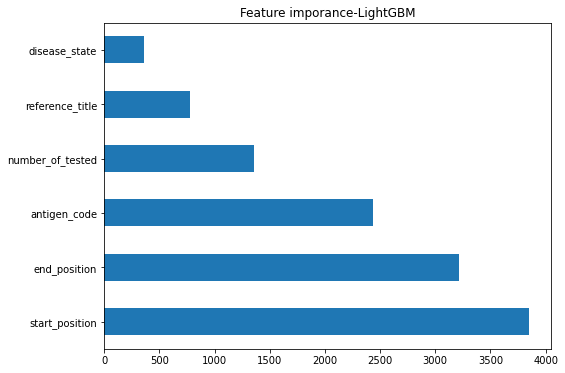

In [6]:
import matplotlib.pyplot as plt

feat_imp = pd.Series(model.feature_importances_, index = X.columns)
feat_imp.nlargest(30).plot(kind = 'barh', figsize = (8,6))
plt.title('Feature imporance-LightGBM')
plt.show()

## Submission

In [33]:
df_submit = pd.read_csv('sample_submission.csv')
y_pred = pd.DataFrame(model.predict(X_test))
df_submit['label'] = y_pred
df_submit.to_csv('lgbm_submit.csv', index=False)
print('Done.')

Done.
